# 使用机器学习合并对象

`ObjectMerger`是[apoc库](https://github.com/haesleinhuepf/apoc)中的一个随机森林分类器，它可以学习哪些标签需要合并，哪些不需要。它允许在对象被（有意或无意地）过度分割后对标签图像进行后处理。

In [1]:
import apoc
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
import numpy as np

一个常见的例子可以从显示细胞膜强度的图像中得到。

cl.OCLArray([[4496., 5212., 6863., ..., 2917., 2680., 2642.],
       [4533., 5146., 7555., ..., 2843., 2857., 2748.],
       [4640., 6082., 8452., ..., 3372., 3039., 3128.],
       ...,
       [1339., 1403., 1359., ..., 4458., 4314., 4795.],
       [1473., 1560., 1622., ..., 3967., 4531., 4204.],
       [1380., 1368., 1649., ..., 3091., 3558., 3682.]], dtype=float32)
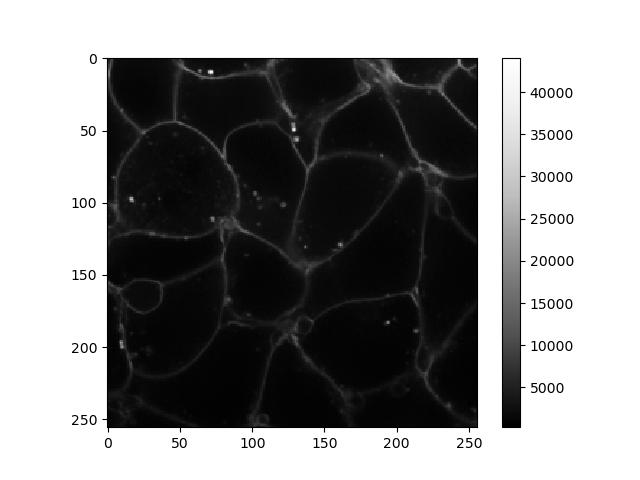
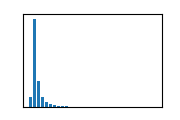

In [2]:
image = imread('../../data/membrane2d.tif')
cle.asarray(image)

由于膜在图像的不同区域具有不同的强度，我们首先需要对此进行校正。

cl.OCLArray([[0.8514066 , 1.0200942 , 1.3921092 , ..., 0.6749894 , 0.6340478 ,
        0.6390664 ],
       [0.8397066 , 0.9866097 , 1.5033678 , ..., 0.6544611 , 0.6719634 ,
        0.6603491 ],
       [0.8410301 , 1.1425375 , 1.6502894 , ..., 0.7734034 , 0.7116847 ,
        0.747907  ],
       ...,
       [0.6833182 , 0.70865285, 0.6797715 , ..., 1.5903093 , 1.5137495 ,
        1.6566108 ],
       [0.7665792 , 0.8030892 , 0.8264799 , ..., 1.3939476 , 1.5649658 ,
        1.4287568 ],
       [0.73148733, 0.71694326, 0.85501015, ..., 1.0721965 , 1.2123575 ,
        1.2338016 ]], dtype=float32)
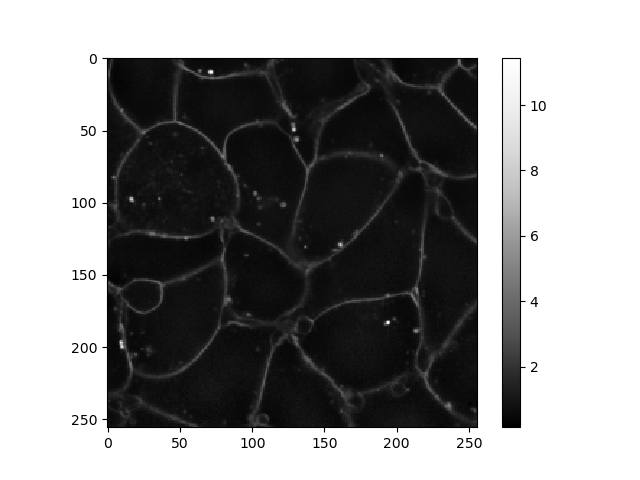
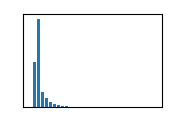

In [3]:
background_subtracted = cle.divide_by_gaussian_background(image, sigma_x=10, sigma_y=10)
background_subtracted

出于技术原因，还建议将强度图像转换为整数类型的图像。因此，可能需要进行归一化。重要的是，用于训练和用于预测的图像应具有相同范围的强度。

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54]], dtype=uint32)
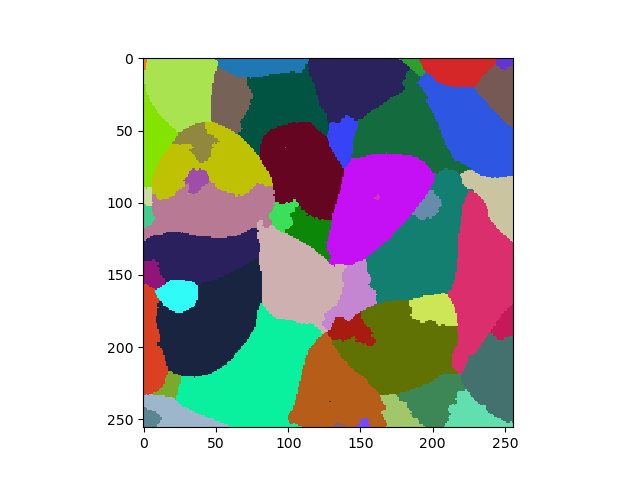

In [4]:
oversegmented = imread("../../data/membrane2d_oversegmented.tif")
cle.asarray(oversegmented).astype(np.uint32)

注释用于告诉算法哪些分割对象应该合并，哪些不应该。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
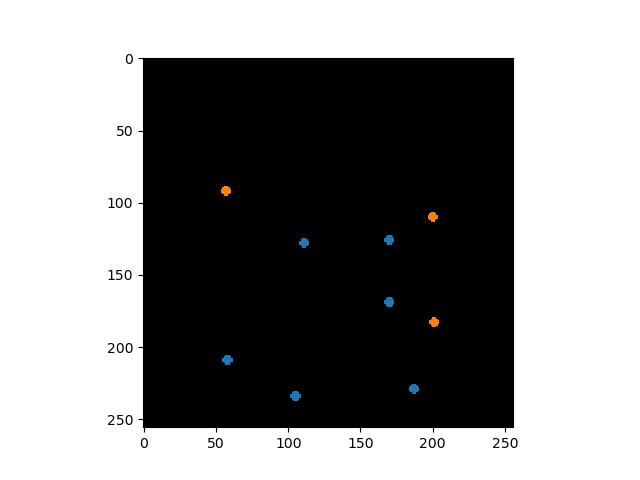

In [5]:
annotation = imread("../../data/membrane2d_merge_annotation.tif")
cle.asarray(annotation).astype(np.uint32)

为了可视化，我们可以将注释与膜图像叠加。

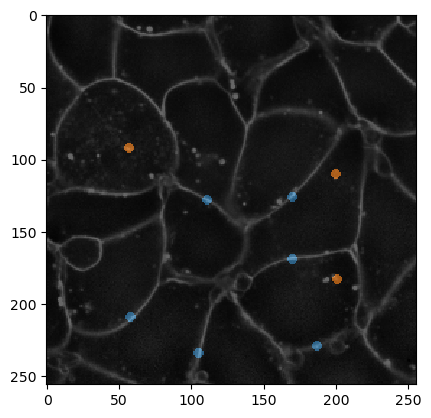

In [6]:
cle.imshow(background_subtracted, max_display_intensity=4, continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

为了更清楚地显示需要注释的内容，我们还叠加了标签边缘图像和注释。请注意，不应合并的边缘是小点，始终仔细地只注释两个对象（不应合并的对象）。

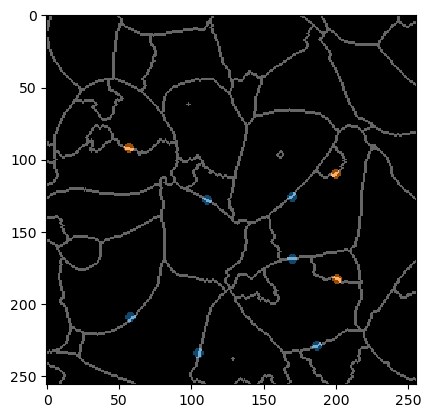

In [7]:
cle.imshow(cle.detect_label_edges(oversegmented), continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

## 训练合并器

`LabelMerger`可以使用三个特征进行训练：
* `touch_portion`：一个对象接触另一个对象的相对数量。例如，在对称的蜂窝状组织中，相邻细胞之间的接触比例为`1/6`。
* `touch_count`：对象接触的像素数。使用此参数时，确保用于训练和预测的图像具有相同的体素大小。
* `mean_touch_intensity`：接触对象之间的平均强度。如果一个细胞被过度分割，在该细胞内会发现多个对象。这些对象接触的区域比两个细胞接触的区域具有较低的强度。因此，它们可以被区分。如上所示的图像归一化是关键。
* `centroid_distance`：标记对象的质心之间的距离（以像素或体素为单位）。

注意：大多数特征建议仅在各向同性图像中使用。

In [8]:
feature_definition = "touch_portion mean_touch_intensity"

classifier_filename = "label_merger.cl"

apoc.erase_classifier(classifier_filename)
classifier = apoc.ObjectMerger(opencl_filename=classifier_filename)

classifier.train(features=feature_definition,
                 labels=oversegmented,
                 sparse_annotation=annotation,
                 image=background_subtracted) 

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31]], dtype=uint32)
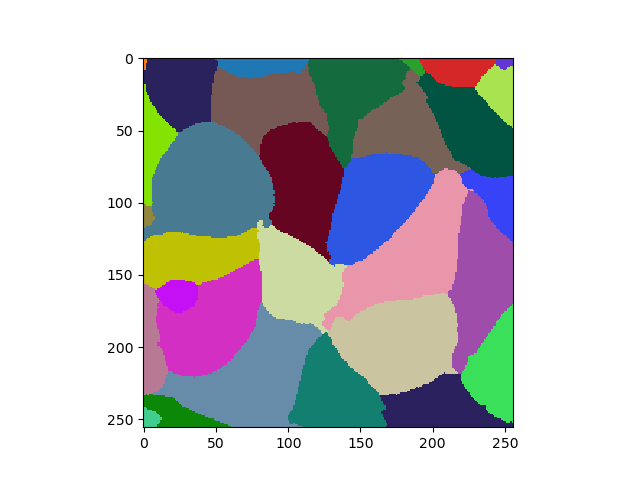

In [9]:
merged_labels = classifier.predict(labels=oversegmented, image=background_subtracted)
merged_labels